In [15]:
%run init_notebookspace.py
from settings import DATA_DIR, MODEL_DIR, POST_EST_DIR

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


<Figure size 1440x432 with 0 Axes>

In [16]:
%matplotlib inline

from gEconpy.classes.model import gEconModel

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import xarray as xr
import pandas as pd

import os
import time

from scipy.stats import gamma, norm, beta, uniform
from filterpy.kalman import KalmanFilter
from filterpy.common import Saver


from src.plotting import plot_dfs
from src.process_data import load_data
from src.filtering_sampling import set_up_kalman_filter, kalman_filter, sample_from_priors, solve_updated_mod, get_arr_pdf_from_dist, kalman_filter_forecast
from src.arima import get_arma_model
from src.utils import printProgBar, get_most_recent_mod_output

from config import plt_config
plt.rcParams.update(plt_config)

load data

In [17]:
from config import fred_dict

df = load_data('prepro_data.csv', DATA_DIR, fred_dict)

# using real potential GDP instead of GDP
df = df.drop(['Ix', 'Zx', 'Y', 'pi_c', 'w'], axis=1).rename(columns={'Y_p': 'Y', 'pi_s': 'pi'})

# split train and test
train = df[df['is_test'] == False].drop('is_test', axis=1).copy()
test = df[df['is_test'] == True].drop('is_test', axis=1).copy()

Error occured 'is_test', file_dict may be incomplete


load & solve model

In [18]:
from config import mod4_params, mod4_priors, mod5_params, mod5_priors
mods = {'mod4_rbc_vanilla': {'params': mod4_params,
                             'priors': mod4_priors,
                             'plot_vars': ['A', 'Y', 'C', 'I', 'L', 'w', 'r', 'lambda']},
        'mod5_nk_vanilla': {'params': mod5_params,
                            'priors': mod5_priors,
                            'plot_vars': ['A', 'Y', 'C', 'I', 'L', 'w', 'r', 'lambda', 'pi', 'pi_obj']}}

# load model
for item in mods.keys():
    mods[item]['mod'] = gEconModel(os.path.join(MODEL_DIR, f'{item}.gcn'), verbose=False)

# solve model
for item in mods.keys():
    _, mods[item]['mod'] = solve_updated_mod(mods[item]['mod'], verbose=False)
    assert _ == True

# load posterior estimates
for key in mods.keys():
    file_name = get_most_recent_mod_output(POST_EST_DIR, key)
    print(file_name)
    mods[key]['post_out'] = xr.open_dataset(os.path.join(POST_EST_DIR, file_name))

mod4_rbc_vanilla_20230327_1229.nc
mod5_nk_vanilla_20230327_1149.nc


#### choose model for futher analysis

In [19]:
name = 'mod5_nk_vanilla'
xarr = mods[name]['post_out']
mod = mods[name]['mod']
prior_dist = mods[name]['priors']
plot_vars = mods[name]['plot_vars']
mod_params = mods[name]['params']

#### posterior quantiles

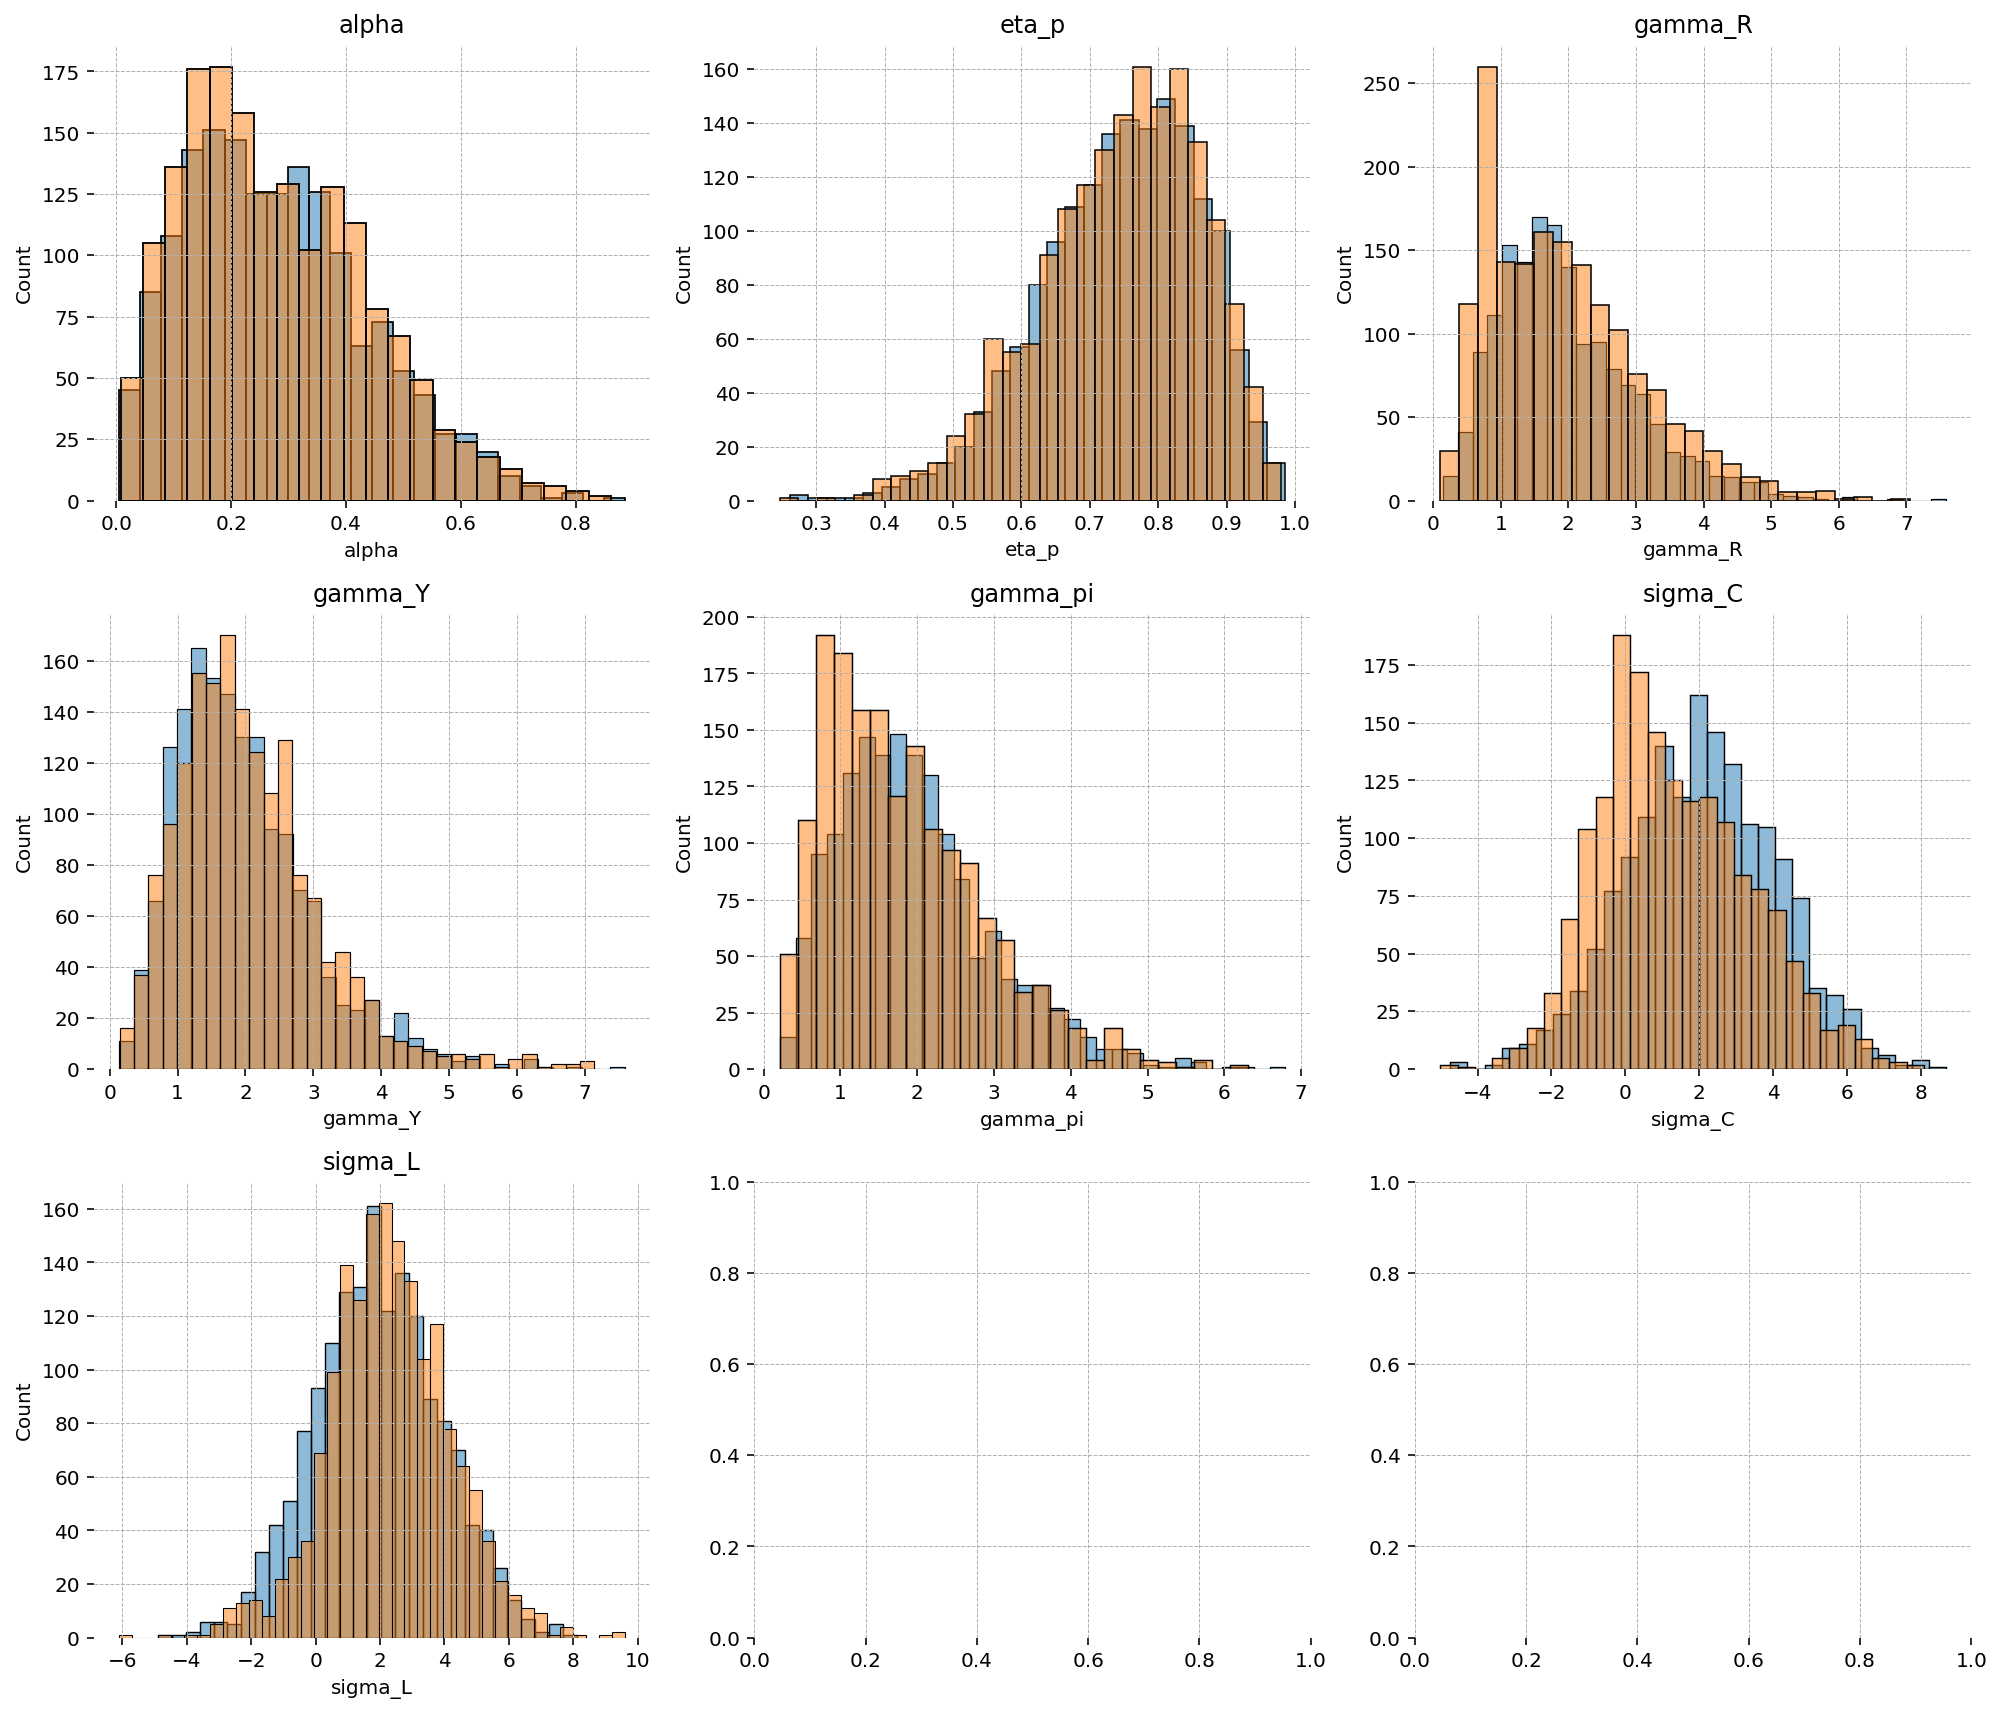

In [20]:
n_runs = xarr.n_runs_acc.values
x1 = pd.DataFrame(xarr.posterior[int(n_runs/2):], columns=xarr.parameter)
x2 = pd.DataFrame([[prior_dist[param].rvs() for item in range(0, int(n_runs/2))] for param in xarr.parameter.values],
                  index=xarr.parameter).transpose()
plot_dfs(dfs_data=[x2, x1], plotfunc=sns.histplot, alpha=.5, legend=['prior', 'posterior'])

0
1
2


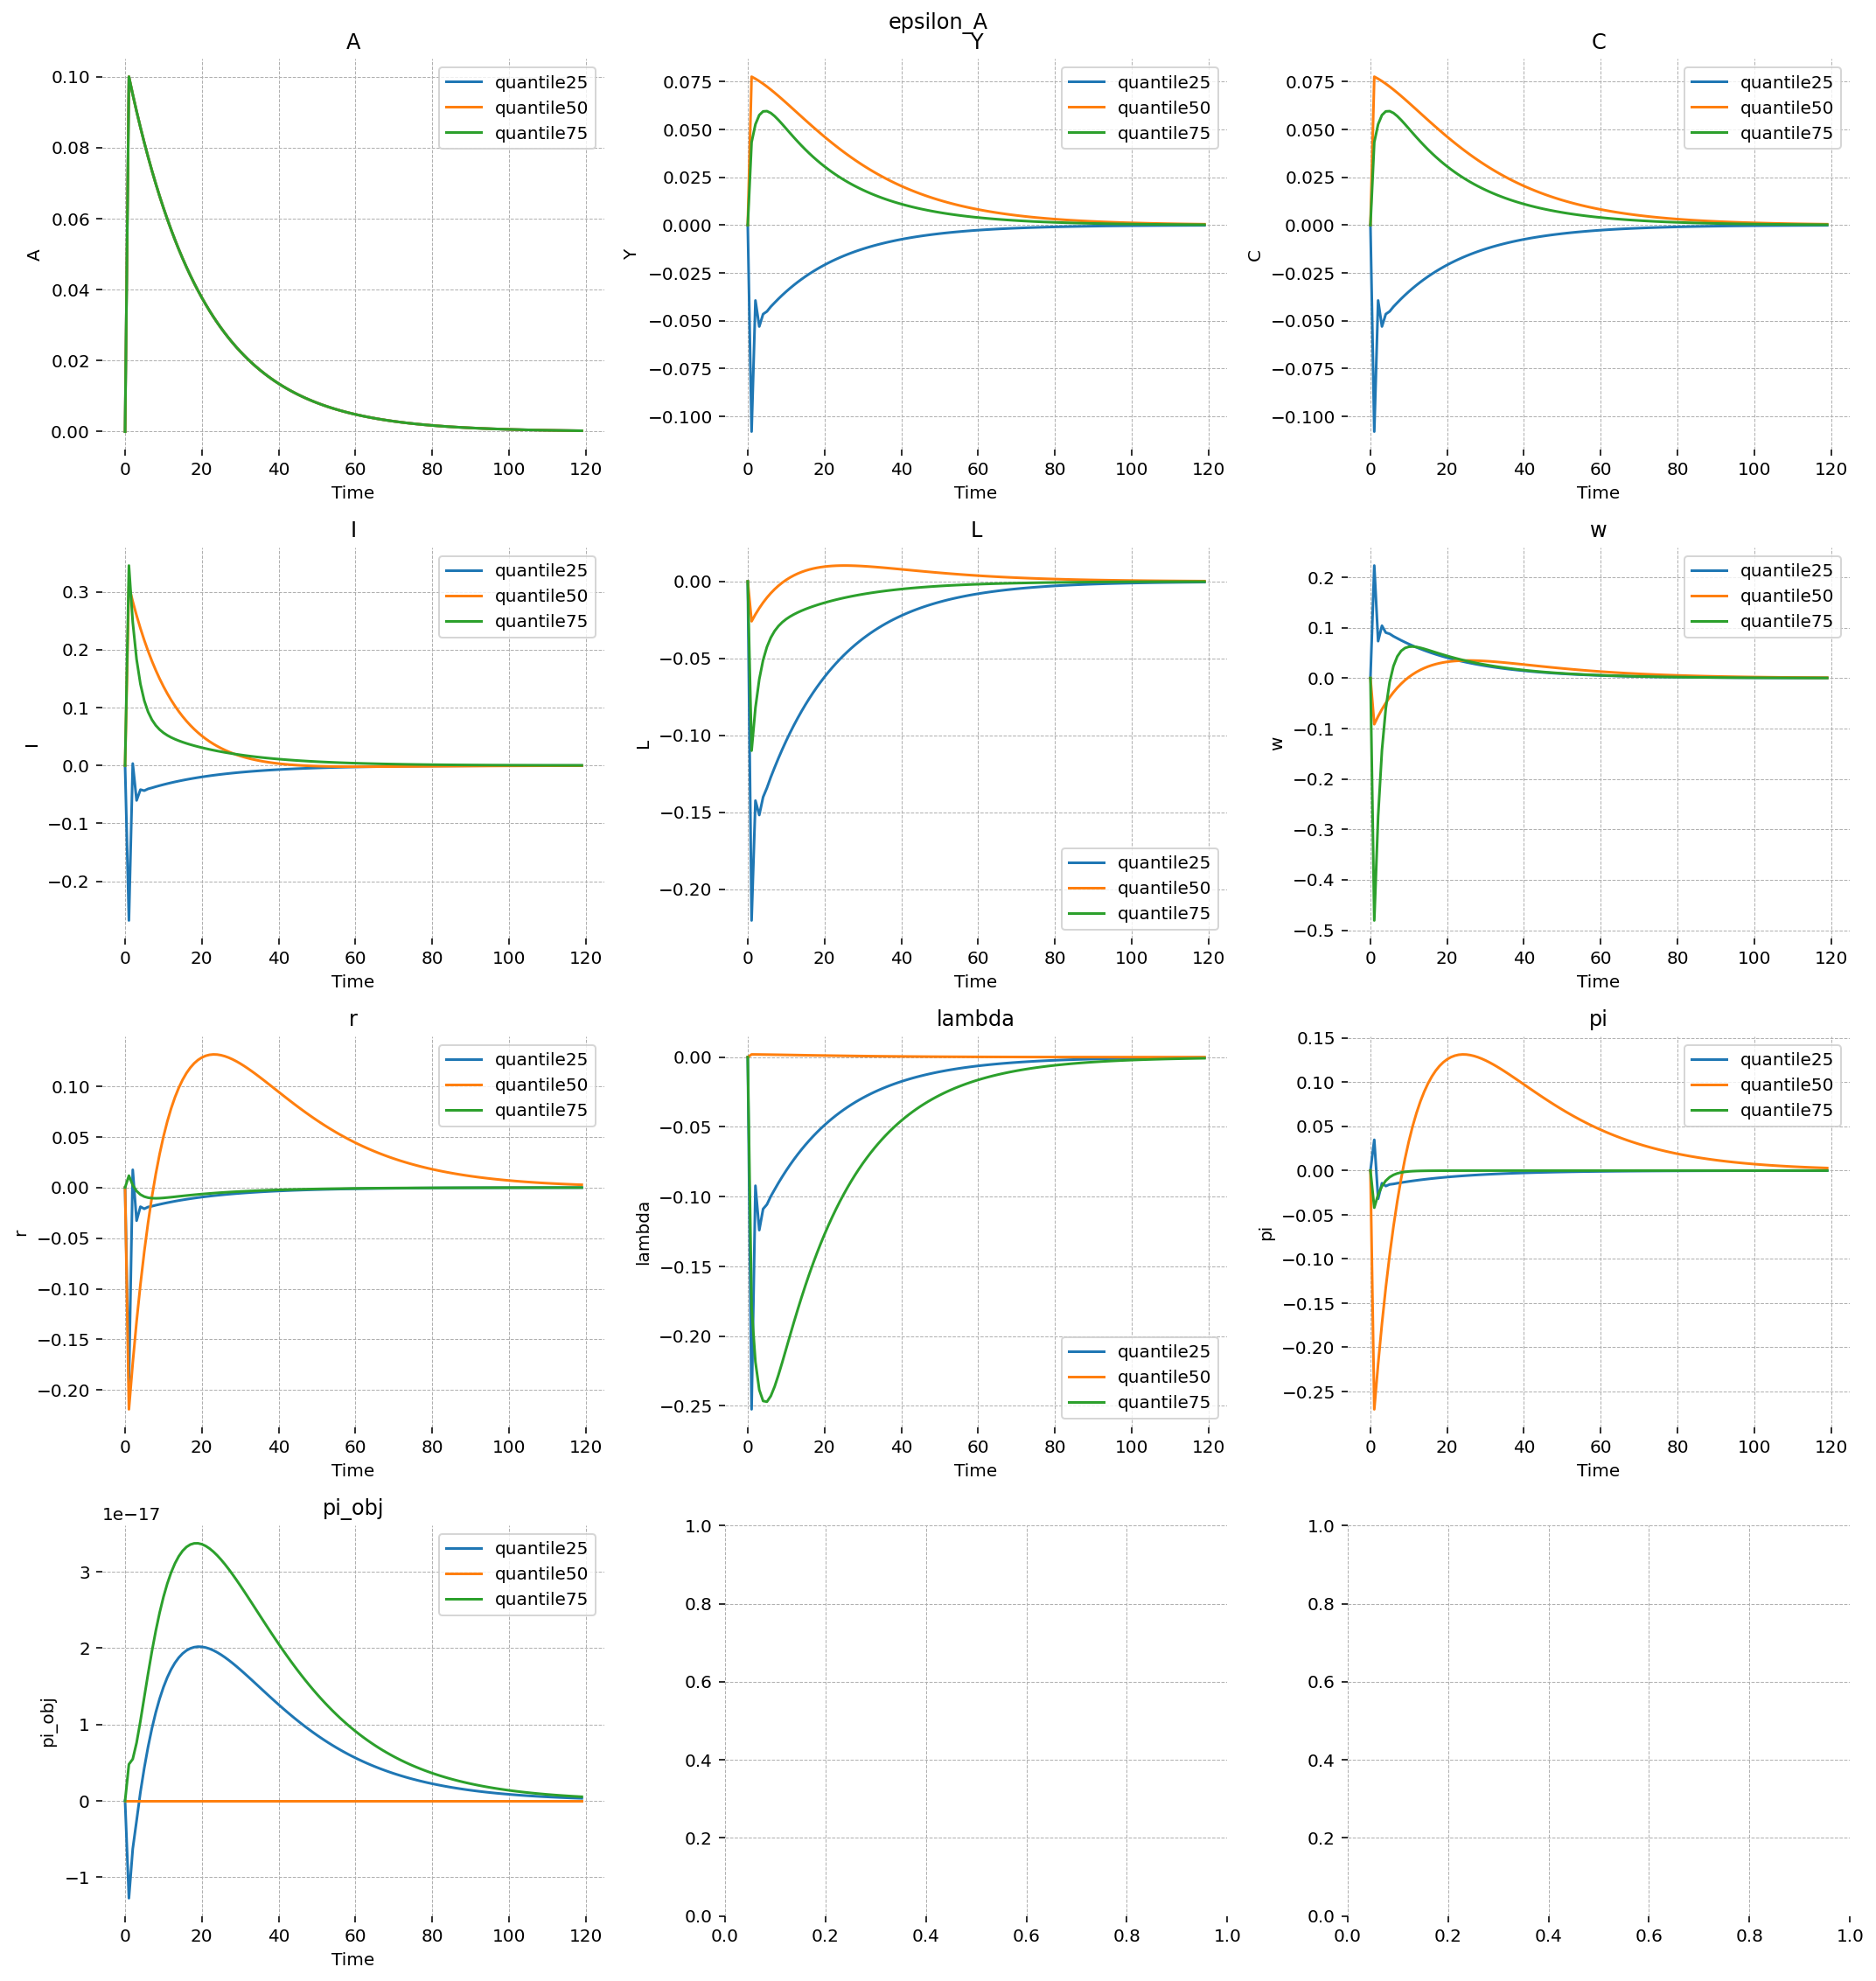

In [21]:
shock_size = .1
sim_length = 120

param_sets = [
    dict(zip(xarr.parameter.values, xarr.posterior_q1)),
    dict(zip(xarr.parameter.values, xarr.posterior_q2)),
    dict(zip(xarr.parameter.values, xarr.posterior_q3))
]

irfs = []
# get irf for each model
for i, params in enumerate(param_sets):
    print(i)
    mod.free_param_dict.update(params)
    _, mod = solve_updated_mod(mod, verbose=False)
    assert _ == True
    irfs.append(mod.impulse_response_function(simulation_length=sim_length, shock_size=shock_size))
    mod.free_param_dict.update(mod_params)
    

# set plotting shock
shock = 'epsilon_A'
for i, irf in enumerate(irfs):
    irfs[i] = irf.unstack().loc[:, shock].unstack().copy()

# plot shocks
plot_dfs([df[mods[name]['plot_vars']] for df in irfs],
         sns.lineplot,
         fig_title=shock,
         figsize=(15, 4),
         legend=['quantile' + str(x) for x in [25, 50, 75]]
        )

#### kalman filter

In [45]:
shock_names = [x.base_name for x in mod.shocks]
state_variables = [x.base_name for x in mod.variables]
observed_vars = ["Y", "pi", "r"]

# update mod params with posterior mean
mod.free_param_dict.update(mod_params)
mod.free_param_dict.update(dict(zip(xarr.parameter.values, xarr.posterior_q2.values)))

_, shocks = sample_from_priors(prior_dist, mod_params, shock_names)

solved, mod = solve_updated_mod(mod, verbose=False)
if not solved: raise ValueError


T, R = mod.T.values, mod.R.values
H, Z, T, R, QN, zs = set_up_kalman_filter(R=R, T=T, observed_data=train[observed_vars].values, observed_vars=observed_vars, 
                                          shock_names=shock_names, shocks_drawn_prior=shocks, state_variables=state_variables, H0=.01)

kfilter = KalmanFilter(len(state_variables), len(observed_vars))
kfilter.F = mod.T
kfilter.Q = QN
kfilter.H = Z
kfilter.R = H

In [46]:
# filtering
saver = Saver(kfilter)
mu, cov, _, _ = kfilter.batch_filter(zs, saver=saver)
ll = saver.log_likelihood
print(np.sum(ll))
mu_df = pd.DataFrame(mu.reshape(len(mu), -1),
                     columns=[item.base_name for item in mod.variables],
                     index=train.index)
cov_df = pd.DataFrame(cov.diagonal(axis1=1, axis2=2), columns=[item.base_name for item in mod.variables], index=train.index)


# forecasting
mu, cov, ll = kalman_filter_forecast(kfilter, test[observed_vars].values)
print(np.sum(ll))

mu_df_test = pd.DataFrame(mu.reshape(len(mu), -1),
                          columns=[item.base_name for item in mod.variables],
                          index=test.index)
cov_df_test = pd.DataFrame(cov.diagonal(axis1=1, axis2=2), columns=[item.base_name for item in mod.variables], index=test.index)

50.96705231371524
13.3725003626445


In [47]:
if ('pi' not in plot_vars) and ('pi' in train.columns): train.drop('pi', axis=1, inplace=True), test.drop('pi', axis=1, inplace=True)

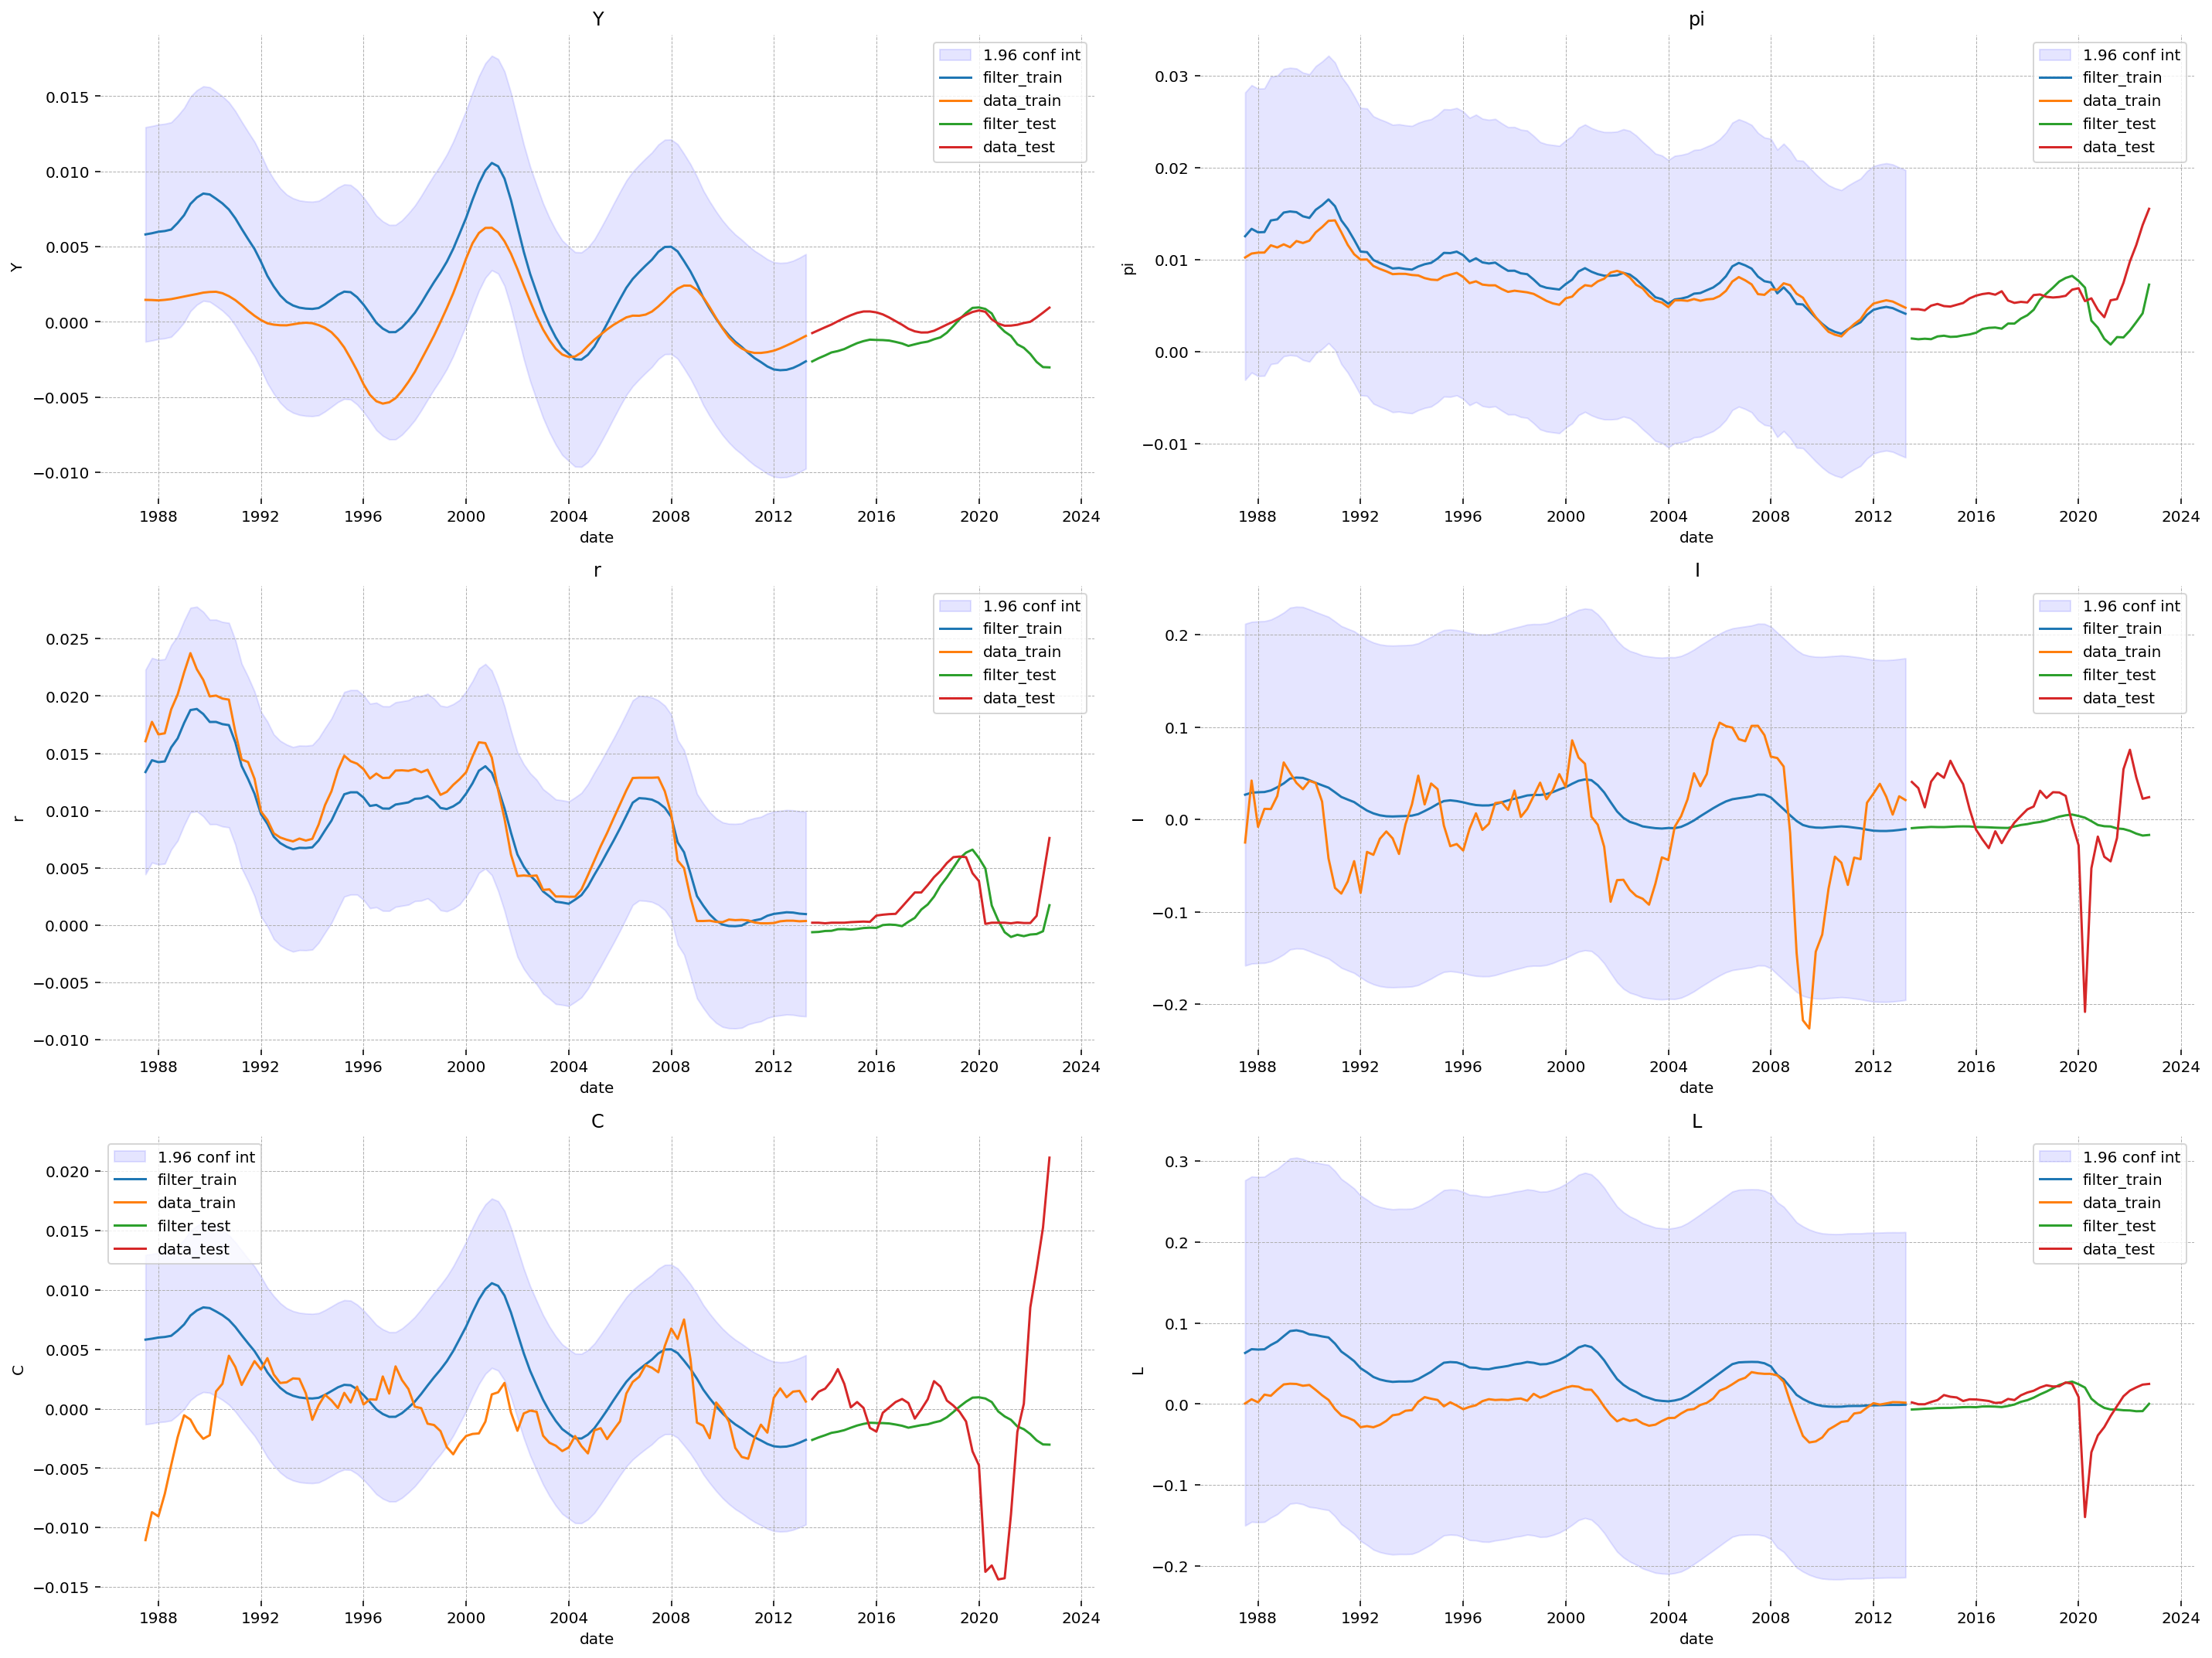

In [48]:
# plot results
ind = 50
plot_dfs([
    mu_df[train.columns].iloc[ind:], 
    train.iloc[ind:], 
    mu_df_test[train.columns],
    test
         ], 
    plotfunc=sns.lineplot, 
    dfs_cov=[
        cov_df.iloc[ind:],
        None,
        None, 
        # cov_df_test
        None,
        None
    ],
    legend=['filter_train', 'data_train', 'filter_test', 'data_test'],
    cols=2,
    figsize=(20, 5)
)

#### arma forecast

In [49]:
out = []
for col in ['Y', 'I', 'C']:
    mu_df, forecasts = get_arma_model(train[col], test[col])
    out.append([train[col], test[col], mu_df, forecasts])

C:\Users\LukasGrahl\Documents\GIT\memoire1\env_memoire1\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\LukasGrahl\Documents\GIT\memoire1\env_memoire1\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


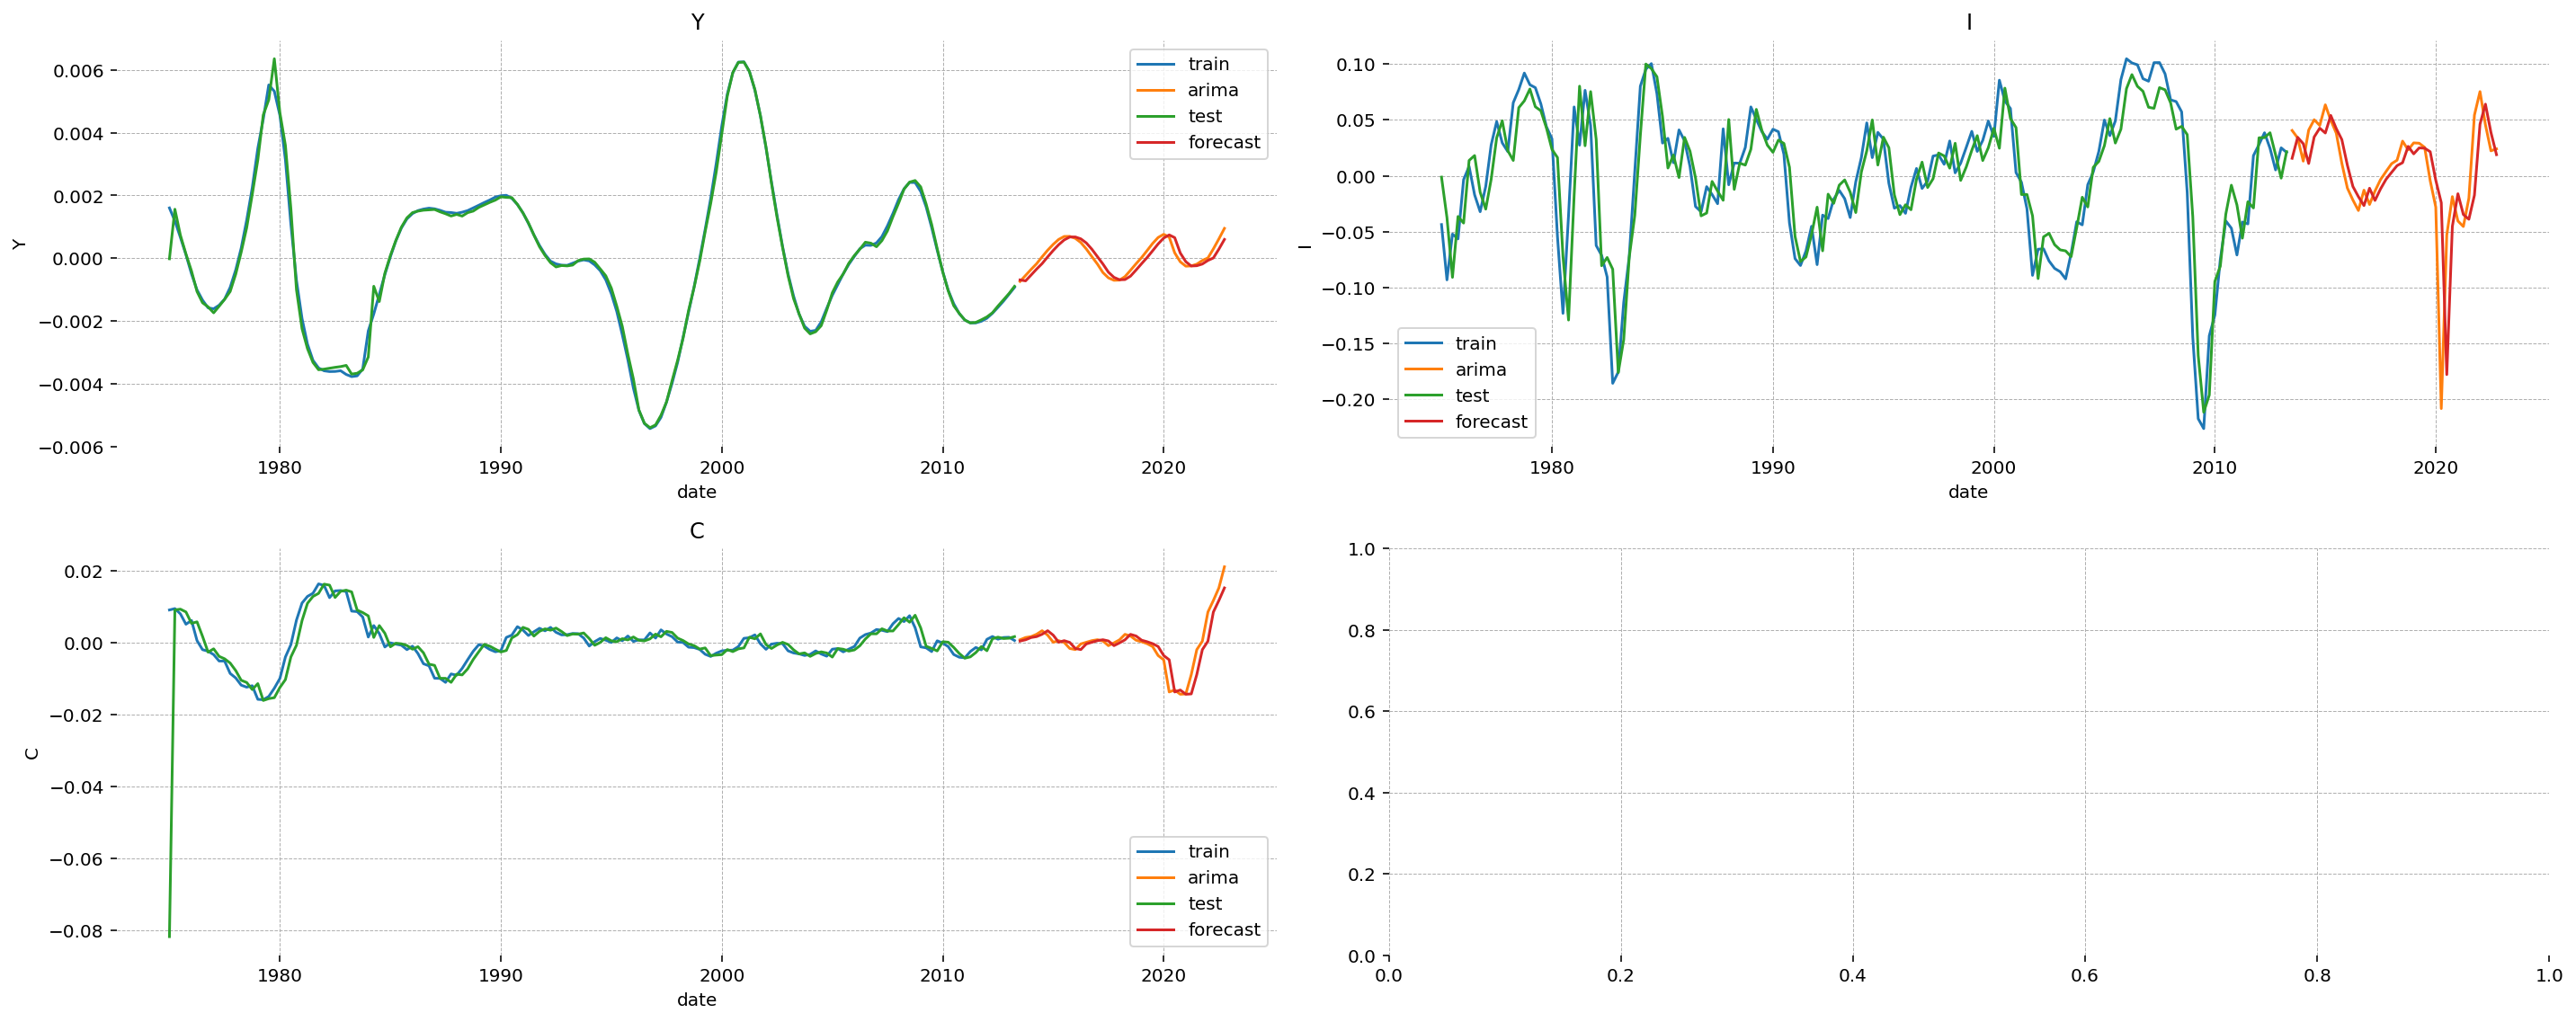

In [50]:
plot_dfs([pd.concat([item[i] for item in out], axis=1) for i in range(0, len(out)+1)],
         sns.lineplot, cols=2, 
         legend=['train', 'arima', 'test', 'forecast'],
         figsize=(20, 4)
)